# Лабораторная работа №5: Градиентный бустинг

## Датасет: Fraud Detection
- **Классификация**: Определение мошеннических транзакций
- **Регрессия**: Предсказание суммы транзакции

## 1. Импорт библиотек

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
)

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
np.random.seed(42)

## 2. Загрузка и подготовка данных

### 2a. Базовый датасет

In [13]:
# Загрузка датасета
df = pd.read_csv('../dataset/fraud-detection/fraud.csv')

print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
print(df.head())
print(f"\nИнформация о датасете:")
print(df.info())
print(f"\nСтатистика:")
print(df.describe())

Размер датасета: (81042, 23)

Первые строки:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0      885451   2019-12-23 04:21:22  6506116513503136   
1      957791   2020-01-20 02:30:18  3523843138706408   
2      134374   2019-03-15 05:42:43   346273234529002   
3      529890   2019-08-16 14:02:32  2712209726293386   
4      772865   2019-11-26 21:22:21  3598215285024754   

                              merchant       category    amt     first  \
0            fraud_Ledner-Pfannerstill  gas_transport  97.75  Kimberly   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport  73.34     Grace   
2                fraud_Halvorson Group       misc_pos   6.09     Donna   
3                    fraud_Yost-Rogahn  personal_care  36.70     Jenna   
4       fraud_Hoppe, Harris and Bednar  entertainment  66.30    Ashley   

       last gender                        street  ...      lat     long  \
0      Rice      F    63991 Destiny Rue Apt. 651  ...  32.2768 -95.3031   
1  Williams      

### 2b. Baseline: разделение на признаки и целевые переменные

In [14]:
# Целевые переменные
y_class = df['is_fraud']  # Классификация
y_reg = df['amt']  # Регрессия

base_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
X_base = df[base_features].copy()

print(f"Базовые признаки: {base_features}")
print(f"Форма X_base: {X_base.shape}")
print(f"\nРаспределение классов:")
print(y_class.value_counts())

Базовые признаки: ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
Форма X_base: (81042, 6)

Распределение классов:
is_fraud
0    80571
1      471
Name: count, dtype: int64


In [15]:
# Разделение на train/test для baseline
X_train_base, X_test_base, y_class_train_base, y_class_test_base = train_test_split(
    X_base, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_train_reg_base, X_test_reg_base, y_reg_train_base, y_reg_test_base = train_test_split(
    X_base, y_reg, test_size=0.2, random_state=42
)

print(f"Train size: {X_train_base.shape[0]}, Test size: {X_test_base.shape[0]}")

Train size: 64833, Test size: 16209


### 2c. Feature Engineering: улучшенные признаки

In [16]:
df_improved = df.copy()

# 1. Временные признаки
df_improved['trans_date_trans_time'] = pd.to_datetime(df_improved['trans_date_trans_time'])
df_improved['hour'] = df_improved['trans_date_trans_time'].dt.hour
df_improved['day_of_week'] = df_improved['trans_date_trans_time'].dt.dayofweek
df_improved['month'] = df_improved['trans_date_trans_time'].dt.month
df_improved['is_weekend'] = (df_improved['day_of_week'] >= 5).astype(int)
df_improved['is_night'] = ((df_improved['hour'] >= 22) | (df_improved['hour'] <= 6)).astype(int)

# 2. Географические признаки
df_improved['distance'] = np.sqrt(
    (df_improved['lat'] - df_improved['merch_lat'])**2 + 
    (df_improved['long'] - df_improved['merch_long'])**2
)

# 3. OneHot encoding для категориальных признаков
categorical_features = ['category', 'gender', 'state']
df_encoded = pd.get_dummies(df_improved, columns=categorical_features, drop_first=True)

# 4. Полиномиальные признаки (взаимодействия)
df_encoded['amt_x_distance'] = df_encoded['amt'] * df_encoded['distance']
df_encoded['amt_x_city_pop'] = df_encoded['amt'] * df_encoded['city_pop']
df_encoded['distance_x_city_pop'] = df_encoded['distance'] * df_encoded['city_pop']

exclude_cols = [
    'is_fraud', 
    'trans_date_trans_time',
    'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'zip',  
    'trans_num', 'unix_time', 'dob',  
    'job'  
]

feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]

numeric_features = []
for col in feature_cols:
    if df_encoded[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool']:
        numeric_features.append(col)
    else:
        print(f"⚠️  Пропускаем нечисловую колонку: {col} (dtype: {df_encoded[col].dtype})")

feature_cols = numeric_features

X_improved = df_encoded[feature_cols].copy()
y_class_improved = df_improved['is_fraud']
y_reg_improved = df_improved['amt']

print(f"\nУлучшенные признаки ({len(feature_cols)} шт.):")
print(f"   Первые 10: {feature_cols[:10]}")
print(f"   Форма X_improved: {X_improved.shape}")
print(f"\nВсе признаки числовые: {X_improved.dtypes.unique()}")



Улучшенные признаки (80 шт.):
   Первые 10: ['Unnamed: 0', 'amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'hour', 'day_of_week', 'month']
   Форма X_improved: (81042, 80)

Все признаки числовые: [dtype('int64') dtype('float64') dtype('int32') dtype('bool')]


In [17]:
# Разделение на train/test для improved
X_train_imp, X_test_imp, y_class_train_imp, y_class_test_imp = train_test_split(
    X_improved, y_class_improved, test_size=0.2, random_state=42, stratify=y_class_improved
)

X_train_reg_imp, X_test_reg_imp, y_reg_train_imp, y_reg_test_imp = train_test_split(
    X_improved, y_reg_improved, test_size=0.2, random_state=42
)

print(f"Improved train size: {X_train_imp.shape[0]}, test size: {X_test_imp.shape[0]}")

Improved train size: 64833, test size: 16209


## 3. Baseline модели (sklearn)

### 3a. Обучение Gradient Boosting (sklearn) на базовых признаках

In [18]:
print("="*60)
print("BASELINE: Gradient Boosting (sklearn) - базовые признаки")
print("="*60)

# Масштабирование
scaler_class_base = StandardScaler()
X_train_base_scaled = scaler_class_base.fit_transform(X_train_base)
X_test_base_scaled = scaler_class_base.transform(X_test_base)

scaler_reg_base = StandardScaler()
X_train_reg_base_scaled = scaler_reg_base.fit_transform(X_train_reg_base)
X_test_reg_base_scaled = scaler_reg_base.transform(X_test_reg_base)

# Классификация
print("\n[Классификация] Обучение GradientBoostingClassifier...")
start_time = time.time()
gb_class_base = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_class_base.fit(X_train_base_scaled, y_class_train_base)
class_train_time_base = time.time() - start_time
print(f"Время обучения: {class_train_time_base:.2f} сек")

# Регрессия
print("\n[Регрессия] Обучение GradientBoostingRegressor...")
start_time = time.time()
gb_reg_base = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)
reg_train_time_base = time.time() - start_time
print(f"Время обучения: {reg_train_time_base:.2f} сек")

# Предсказания
y_class_pred_base = gb_class_base.predict(X_test_base_scaled)
y_class_proba_base = gb_class_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_base = gb_reg_base.predict(X_test_reg_base_scaled)

print("\n" + "="*60)

BASELINE: Gradient Boosting (sklearn) - базовые признаки

[Классификация] Обучение GradientBoostingClassifier...
Время обучения: 11.68 сек

[Регрессия] Обучение GradientBoostingRegressor...
Время обучения: 11.26 сек



### 3b. Оценка качества baseline

In [19]:
print("\n" + "="*60)
print("МЕТРИКИ BASELINE")
print("="*60)

# Классификация
print("\n[Классификация]")
acc_base = accuracy_score(y_class_test_base, y_class_pred_base)
prec_base = precision_score(y_class_test_base, y_class_pred_base, zero_division=0)
rec_base = recall_score(y_class_test_base, y_class_pred_base, zero_division=0)
f1_base = f1_score(y_class_test_base, y_class_pred_base, zero_division=0)
auc_base = roc_auc_score(y_class_test_base, y_class_proba_base)

print(f"Accuracy:  {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall:    {rec_base:.4f}")
print(f"F1-Score:  {f1_base:.4f}")
print(f"ROC-AUC:   {auc_base:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_class_test_base, y_class_pred_base))

# Регрессия
print("\n[Регрессия]")
mae_base = mean_absolute_error(y_reg_test_base, y_reg_pred_base)
mse_base = mean_squared_error(y_reg_test_base, y_reg_pred_base)
r2_base = r2_score(y_reg_test_base, y_reg_pred_base)

print(f"MAE:  {mae_base:.4f}")
print(f"MSE:  {mse_base:.4f}")
print(f"R²:   {r2_base:.4f}")

# Сохранение результатов
baseline_results = {
    'classification': {
        'accuracy': acc_base,
        'precision': prec_base,
        'recall': rec_base,
        'f1': f1_base,
        'roc_auc': auc_base,
        'train_time': class_train_time_base
    },
    'regression': {
        'mae': mae_base,
        'mse': mse_base,
        'r2': r2_base,
        'train_time': reg_train_time_base
    }
}


МЕТРИКИ BASELINE

[Классификация]
Accuracy:  0.9947
Precision: 0.5952
Recall:    0.2660
F1-Score:  0.3676
ROC-AUC:   0.9589

Confusion Matrix:
[[16098    17]
 [   69    25]]

[Регрессия]
MAE:  1.2585
MSE:  344.0235
R²:   0.9828


## 3c. Улучшенная модель (sklearn) с Optuna на улучшенных признаках

### Optuna: подбор гиперпараметров

In [20]:
print("="*60)
print("OPTUNA: Подбор гиперпараметров для Gradient Boosting")
print("="*60)

# Масштабирование улучшенных признаков
scaler_class_imp = StandardScaler()
X_train_imp_scaled = scaler_class_imp.fit_transform(X_train_imp)
X_test_imp_scaled = scaler_class_imp.transform(X_test_imp)

scaler_reg_imp = StandardScaler()
X_train_reg_imp_scaled = scaler_reg_imp.fit_transform(X_train_reg_imp)
X_test_reg_imp_scaled = scaler_reg_imp.transform(X_test_reg_imp)

# Objective функция для классификации
def objective_classification(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = GradientBoostingClassifier(**params)
    model.fit(X_train_imp_scaled, y_class_train_imp)
    y_pred = model.predict(X_test_imp_scaled)
    return f1_score(y_class_test_imp, y_pred, zero_division=0)

print("\n[Классификация] Оптимизация...")
study_class = optuna.create_study(direction='maximize')
study_class.optimize(objective_classification, n_trials=10, show_progress_bar=True, n_jobs=-1)

print(f"\nЛучшие параметры: {study_class.best_params}")
print(f"F1-Score: {study_class.best_value:.4f}")

best_params_class = study_class.best_params

OPTUNA: Подбор гиперпараметров для Gradient Boosting

[Классификация] Оптимизация...


  0%|          | 0/20 [00:00<?, ?it/s]


Лучшие параметры: {'n_estimators': 282, 'learning_rate': 0.01604490350291691, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 5, 'subsample': 0.9863139639868446, 'max_features': None}
F1-Score: 0.7381


In [21]:
# Objective функция для регрессии
def objective_regression(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = GradientBoostingRegressor(**params)
    model.fit(X_train_reg_imp_scaled, y_reg_train_imp)
    y_pred = model.predict(X_test_reg_imp_scaled)
    return r2_score(y_reg_test_imp, y_pred)

print("\n[Регрессия] Оптимизация...")
study_reg = optuna.create_study(direction='maximize')
study_reg.optimize(objective_regression, n_trials=10, show_progress_bar=True, n_jobs=-1)

print(f"\nЛучшие параметры: {study_reg.best_params}")
print(f"R² Score: {study_reg.best_value:.4f}")

best_params_reg = study_reg.best_params


[Регрессия] Оптимизация...


  0%|          | 0/10 [00:00<?, ?it/s]


Лучшие параметры: {'n_estimators': 165, 'learning_rate': 0.015696841793196407, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 2, 'subsample': 0.6947053427871567, 'max_features': None}
R² Score: 0.9630


### 3d. Обучение улучшенных моделей

In [22]:
print("="*60)
print("IMPROVED: Обучение с лучшими гиперпараметрами")
print("="*60)

# Классификация
print("\n[Классификация] Обучение с Optuna параметрами...")
start_time = time.time()
gb_class_imp = GradientBoostingClassifier(**best_params_class)
gb_class_imp.fit(X_train_imp_scaled, y_class_train_imp)
class_train_time_imp = time.time() - start_time
print(f"Время обучения: {class_train_time_imp:.2f} сек")

# Регрессия
print("\n[Регрессия] Обучение с Optuna параметрами...")
start_time = time.time()
gb_reg_imp = GradientBoostingRegressor(**best_params_reg)
gb_reg_imp.fit(X_train_reg_imp_scaled, y_reg_train_imp)
reg_train_time_imp = time.time() - start_time
print(f"Время обучения: {reg_train_time_imp:.2f} сек")

# Предсказания
y_class_pred_imp = gb_class_imp.predict(X_test_imp_scaled)
y_class_proba_imp = gb_class_imp.predict_proba(X_test_imp_scaled)[:, 1]
y_reg_pred_imp = gb_reg_imp.predict(X_test_reg_imp_scaled)

print("\n" + "="*60)

IMPROVED: Обучение с лучшими гиперпараметрами

[Классификация] Обучение с Optuna параметрами...
Время обучения: 289.74 сек

[Регрессия] Обучение с Optuna параметрами...
Время обучения: 39.94 сек



### 3e. Оценка качества улучшенной модели

In [23]:
print("\n" + "="*60)
print("МЕТРИКИ IMPROVED")
print("="*60)

# Классификация
print("\n[Классификация]")
acc_imp = accuracy_score(y_class_test_imp, y_class_pred_imp)
prec_imp = precision_score(y_class_test_imp, y_class_pred_imp, zero_division=0)
rec_imp = recall_score(y_class_test_imp, y_class_pred_imp, zero_division=0)
f1_imp = f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0)
auc_imp = roc_auc_score(y_class_test_imp, y_class_proba_imp)

print(f"Accuracy:  {acc_imp:.4f}")
print(f"Precision: {prec_imp:.4f}")
print(f"Recall:    {rec_imp:.4f}")
print(f"F1-Score:  {f1_imp:.4f}")
print(f"ROC-AUC:   {auc_imp:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_class_test_imp, y_class_pred_imp))

# Регрессия
print("\n[Регрессия]")
mae_imp = mean_absolute_error(y_reg_test_imp, y_reg_pred_imp)
mse_imp = mean_squared_error(y_reg_test_imp, y_reg_pred_imp)
r2_imp = r2_score(y_reg_test_imp, y_reg_pred_imp)

print(f"MAE:  {mae_imp:.4f}")
print(f"MSE:  {mse_imp:.4f}")
print(f"R²:   {r2_imp:.4f}")

# Сохранение результатов
improved_results = {
    'classification': {
        'accuracy': acc_imp,
        'precision': prec_imp,
        'recall': rec_imp,
        'f1': f1_imp,
        'roc_auc': auc_imp,
        'train_time': class_train_time_imp
    },
    'regression': {
        'mae': mae_imp,
        'mse': mse_imp,
        'r2': r2_imp,
        'train_time': reg_train_time_imp
    }
}


МЕТРИКИ IMPROVED

[Классификация]
Accuracy:  0.9973
Precision: 0.8378
Recall:    0.6596
F1-Score:  0.7381
ROC-AUC:   0.9848

Confusion Matrix:
[[16103    12]
 [   32    62]]

[Регрессия]
MAE:  7.9048
MSE:  932.4733
R²:   0.9534


### 3f. Сравнение Baseline vs Improved

In [24]:
print("="*60)
print("СРАВНЕНИЕ: Baseline vs Improved (sklearn)")
print("="*60)

print("\n[Классификация]")
print(f"{'Метрика':<15} {'Baseline':<12} {'Improved':<12} {'Изменение, %':<12}")
print("-"*55)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    base_val = baseline_results['classification'][metric]
    imp_val = improved_results['classification'][metric]
    change = ((imp_val - base_val) / base_val * 100) if base_val != 0 else 0
    print(f"{metric:<15} {base_val:<12.4f} {imp_val:<12.4f} {change:>+11.2f}%")

print(f"\nВремя обучения: {baseline_results['classification']['train_time']:.2f}s → {improved_results['classification']['train_time']:.2f}s")

print("\n" + "-"*55)
print("\n[Регрессия]")
print(f"{'Метрика':<15} {'Baseline':<12} {'Improved':<12} {'Изменение, %':<12}")
print("-"*55)
for metric in ['mae', 'mse', 'r2']:
    base_val = baseline_results['regression'][metric]
    imp_val = improved_results['regression'][metric]
    if metric in ['mae', 'mse']:
        change = ((base_val - imp_val) / base_val * 100) if base_val != 0 else 0
        print(f"{metric:<15} {base_val:<12.4f} {imp_val:<12.4f} {change:>+11.2f}%")
    else:
        change = ((imp_val - base_val) / abs(base_val) * 100) if base_val != 0 else 0
        print(f"{metric:<15} {base_val:<12.4f} {imp_val:<12.4f} {change:>+11.2f}%")

print(f"\nВремя обучения: {baseline_results['regression']['train_time']:.2f}s → {improved_results['regression']['train_time']:.2f}s")

СРАВНЕНИЕ: Baseline vs Improved (sklearn)

[Классификация]
Метрика         Baseline     Improved     Изменение, %
-------------------------------------------------------
accuracy        0.9947       0.9973             +0.26%
precision       0.5952       0.8378            +40.76%
recall          0.2660       0.6596           +148.00%
f1              0.3676       0.7381           +100.76%
roc_auc         0.9589       0.9848             +2.71%

Время обучения: 11.68s → 289.74s

-------------------------------------------------------

[Регрессия]
Метрика         Baseline     Improved     Изменение, %
-------------------------------------------------------
mae             1.2585       7.9048           -528.10%
mse             344.0235     932.4733         -171.05%
r2              0.9828       0.9534             -2.99%

Время обучения: 11.26s → 39.94s


## 4. Custom Gradient Boosting

### 4a. Реализация алгоритма

In [25]:
# Custom Gradient Boosting Implementation
from sklearn.tree import DecisionTreeRegressor

class CustomGradientBoosting:
    """
    Упрощённая реализация Gradient Boosting для классификации и регрессии.
    Использует решающие деревья в качестве базовых моделей.
    """

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, min_samples_leaf=1, subsample=1.0,
                 task='classification', random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.task = task
        self.random_state = random_state
        self.trees = []
        self.initial_prediction = None

    def _sigmoid(self, x):
        """Сигмоида для классификации"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def _compute_residuals(self, y, predictions):
        """Вычисление остатков (градиентов)"""
        if self.task == 'classification':
            # Для логистической регрессии: y - sigmoid(pred)
            probs = self._sigmoid(predictions)
            return y - probs
        else:
            # Для регрессии: y - pred
            return y - predictions

    def _subsample_data(self, X, y, residuals):
        """Подвыборка данных для stochastic gradient boosting"""
        if self.subsample < 1.0:
            n_samples = int(self.subsample * len(X))
            indices = np.random.choice(len(X), n_samples, replace=False)
            return X[indices], residuals[indices]
        return X, residuals

    def fit(self, X, y):
        """Обучение модели"""
        np.random.seed(self.random_state)
        X = np.array(X)
        y = np.array(y)

        # Начальное предсказание
        if self.task == 'classification':
            # Логит от среднего класса
            mean_class = np.mean(y)
            self.initial_prediction = np.log(mean_class / (1 - mean_class + 1e-10))
        else:
            # Среднее значение
            self.initial_prediction = np.mean(y)

        # Инициализация предсказаний
        predictions = np.full(len(y), self.initial_prediction)

        # Обучение деревьев
        for i in range(self.n_estimators):
            # Вычисление остатков (антиградиентов)
            residuals = self._compute_residuals(y, predictions)

            # Подвыборка
            X_sub, residuals_sub = self._subsample_data(X, y, residuals)

            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i
            )
            tree.fit(X_sub, residuals_sub)

            # Обновление предсказаний
            update = tree.predict(X)
            predictions += self.learning_rate * update

            self.trees.append(tree)

        return self

    def predict(self, X):
        """Предсказание"""
        X = np.array(X)
        predictions = np.full(len(X), self.initial_prediction)

        # Суммирование предсказаний всех деревьев
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        if self.task == 'classification':
            # Возвращаем классы (0 или 1)
            probs = self._sigmoid(predictions)
            return (probs >= 0.5).astype(int)
        else:
            return predictions

    def predict_proba(self, X):
        """Предсказание вероятностей (только для классификации)"""
        if self.task != 'classification':
            raise ValueError("predict_proba доступен только для классификации")

        X = np.array(X)
        predictions = np.full(len(X), self.initial_prediction)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        probs = self._sigmoid(predictions)
        return np.column_stack([1 - probs, probs])

print("✓ CustomGradientBoosting реализован")

✓ CustomGradientBoosting реализован


### 4b. Обучение Custom Gradient Boosting на baseline

In [26]:
print("="*60)
print("CUSTOM BASELINE: Gradient Boosting - базовые признаки")
print("="*60)

# Классификация
print("\n[Классификация] Обучение CustomGradientBoosting...")
start_time = time.time()
custom_gb_class_base = CustomGradientBoosting(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=0.8,
    task='classification',
    random_state=42
)
custom_gb_class_base.fit(X_train_base_scaled, y_class_train_base)
custom_class_train_time_base = time.time() - start_time
print(f"Время обучения: {custom_class_train_time_base:.2f} сек")

# Регрессия
print("\n[Регрессия] Обучение CustomGradientBoosting...")
start_time = time.time()
custom_gb_reg_base = CustomGradientBoosting(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=0.8,
    task='regression',
    random_state=42
)
custom_gb_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)
custom_reg_train_time_base = time.time() - start_time
print(f"Время обучения: {custom_reg_train_time_base:.2f} сек")

# Предсказания
y_class_pred_custom_base = custom_gb_class_base.predict(X_test_base_scaled)
y_class_proba_custom_base = custom_gb_class_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_custom_base = custom_gb_reg_base.predict(X_test_reg_base_scaled)

print("\n" + "="*60)

CUSTOM BASELINE: Gradient Boosting - базовые признаки

[Классификация] Обучение CustomGradientBoosting...
Время обучения: 9.23 сек

[Регрессия] Обучение CustomGradientBoosting...
Время обучения: 9.04 сек



### 4c. Метрики Custom Baseline

In [27]:
print("\n" + "="*60)
print("МЕТРИКИ CUSTOM BASELINE")
print("="*60)

# Классификация
print("\n[Классификация]")
custom_acc_base = accuracy_score(y_class_test_base, y_class_pred_custom_base)
custom_prec_base = precision_score(y_class_test_base, y_class_pred_custom_base, zero_division=0)
custom_rec_base = recall_score(y_class_test_base, y_class_pred_custom_base, zero_division=0)
custom_f1_base = f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0)
custom_auc_base = roc_auc_score(y_class_test_base, y_class_proba_custom_base)

print(f"Accuracy:  {custom_acc_base:.4f}")
print(f"Precision: {custom_prec_base:.4f}")
print(f"Recall:    {custom_rec_base:.4f}")
print(f"F1-Score:  {custom_f1_base:.4f}")
print(f"ROC-AUC:   {custom_auc_base:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_class_test_base, y_class_pred_custom_base))

# Регрессия
print("\n[Регрессия]")
custom_mae_base = mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base)
custom_mse_base = mean_squared_error(y_reg_test_base, y_reg_pred_custom_base)
custom_r2_base = r2_score(y_reg_test_base, y_reg_pred_custom_base)

print(f"MAE:  {custom_mae_base:.4f}")
print(f"MSE:  {custom_mse_base:.4f}")
print(f"R²:   {custom_r2_base:.4f}")

# Сохранение результатов
custom_baseline_results = {
    'classification': {
        'accuracy': custom_acc_base,
        'precision': custom_prec_base,
        'recall': custom_rec_base,
        'f1': custom_f1_base,
        'roc_auc': custom_auc_base,
        'train_time': custom_class_train_time_base
    },
    'regression': {
        'mae': custom_mae_base,
        'mse': custom_mse_base,
        'r2': custom_r2_base,
        'train_time': custom_reg_train_time_base
    }
}


МЕТРИКИ CUSTOM BASELINE

[Классификация]
Accuracy:  0.9942
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.9303

Confusion Matrix:
[[16115     0]
 [   94     0]]

[Регрессия]
MAE:  1.3355
MSE:  223.0653
R²:   0.9889


### 4d. Сравнение sklearn vs Custom (baseline)

In [28]:
print("="*60)
print("СРАВНЕНИЕ: sklearn vs Custom (Baseline)")
print("="*60)

print("\n[Классификация]")
print(f"{'Метрика':<15} {'sklearn':<12} {'Custom':<12} {'Разница':<12}")
print("-"*55)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    sklearn_val = baseline_results['classification'][metric]
    custom_val = custom_baseline_results['classification'][metric]
    diff = custom_val - sklearn_val
    print(f"{metric:<15} {sklearn_val:<12.4f} {custom_val:<12.4f} {diff:>+11.4f}")

sklearn_time = baseline_results['classification']['train_time']
custom_time = custom_baseline_results['classification']['train_time']
slowdown = custom_time / sklearn_time if sklearn_time > 0 else 0
print(f"\nВремя: {sklearn_time:.2f}s (sklearn) vs {custom_time:.2f}s (custom)")
print(f"Замедление: {slowdown:.2f}x")

print("\n" + "-"*55)
print("\n[Регрессия]")
print(f"{'Метрика':<15} {'sklearn':<12} {'Custom':<12} {'Разница':<12}")
print("-"*55)
for metric in ['mae', 'mse', 'r2']:
    sklearn_val = baseline_results['regression'][metric]
    custom_val = custom_baseline_results['regression'][metric]
    diff = custom_val - sklearn_val
    print(f"{metric:<15} {sklearn_val:<12.4f} {custom_val:<12.4f} {diff:>+11.4f}")

sklearn_time_reg = baseline_results['regression']['train_time']
custom_time_reg = custom_baseline_results['regression']['train_time']
slowdown_reg = custom_time_reg / sklearn_time_reg if sklearn_time_reg > 0 else 0
print(f"\nВремя: {sklearn_time_reg:.2f}s (sklearn) vs {custom_time_reg:.2f}s (custom)")
print(f"Замедление: {slowdown_reg:.2f}x")

СРАВНЕНИЕ: sklearn vs Custom (Baseline)

[Классификация]
Метрика         sklearn      Custom       Разница     
-------------------------------------------------------
accuracy        0.9947       0.9942           -0.0005
precision       0.5952       0.0000           -0.5952
recall          0.2660       0.0000           -0.2660
f1              0.3676       0.0000           -0.3676
roc_auc         0.9589       0.9303           -0.0286

Время: 11.68s (sklearn) vs 9.23s (custom)
Замедление: 0.79x

-------------------------------------------------------

[Регрессия]
Метрика         sklearn      Custom       Разница     
-------------------------------------------------------
mae             1.2585       1.3355           +0.0769
mse             344.0235     223.0653       -120.9582
r2              0.9828       0.9889           +0.0060

Время: 11.26s (sklearn) vs 9.04s (custom)
Замедление: 0.80x


### 4e. Обучение Custom Gradient Boosting с улучшенными признаками

In [29]:
print("="*60)
print("CUSTOM IMPROVED: с feature engineering")
print("="*60)

# Используем лучшие параметры из Optuna для custom модели
print("\n[Классификация] Обучение CustomGradientBoosting с Optuna параметрами...")
start_time = time.time()
custom_gb_class_imp = CustomGradientBoosting(
    n_estimators=best_params_class.get('n_estimators', 100),
    learning_rate=best_params_class.get('learning_rate', 0.1),
    max_depth=best_params_class.get('max_depth', 3),
    min_samples_split=best_params_class.get('min_samples_split', 2),
    min_samples_leaf=best_params_class.get('min_samples_leaf', 1),
    subsample=best_params_class.get('subsample', 0.8),
    task='classification',
    random_state=42
)
custom_gb_class_imp.fit(X_train_imp_scaled, y_class_train_imp)
custom_class_train_time_imp = time.time() - start_time
print(f"Время обучения: {custom_class_train_time_imp:.2f} сек")

print("\n[Регрессия] Обучение CustomGradientBoosting с Optuna параметрами...")
start_time = time.time()
custom_gb_reg_imp = CustomGradientBoosting(
    n_estimators=best_params_reg.get('n_estimators', 100),
    learning_rate=best_params_reg.get('learning_rate', 0.1),
    max_depth=best_params_reg.get('max_depth', 3),
    min_samples_split=best_params_reg.get('min_samples_split', 2),
    min_samples_leaf=best_params_reg.get('min_samples_leaf', 1),
    subsample=best_params_reg.get('subsample', 0.8),
    task='regression',
    random_state=42
)
custom_gb_reg_imp.fit(X_train_reg_imp_scaled, y_reg_train_imp)
custom_reg_train_time_imp = time.time() - start_time
print(f"Время обучения: {custom_reg_train_time_imp:.2f} сек")

# Предсказания
y_class_pred_custom_imp = custom_gb_class_imp.predict(X_test_imp_scaled)
y_class_proba_custom_imp = custom_gb_class_imp.predict_proba(X_test_imp_scaled)[:, 1]
y_reg_pred_custom_imp = custom_gb_reg_imp.predict(X_test_reg_imp_scaled)

print("\n" + "="*60)

CUSTOM IMPROVED: с feature engineering

[Классификация] Обучение CustomGradientBoosting с Optuna параметрами...
Время обучения: 336.20 сек

[Регрессия] Обучение CustomGradientBoosting с Optuna параметрами...
Время обучения: 57.25 сек



### 4f. Метрики Custom Improved

In [30]:
print("\n" + "="*60)
print("МЕТРИКИ CUSTOM IMPROVED")
print("="*60)

# Классификация
print("\n[Классификация]")
custom_acc_imp = accuracy_score(y_class_test_imp, y_class_pred_custom_imp)
custom_prec_imp = precision_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0)
custom_rec_imp = recall_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0)
custom_f1_imp = f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0)
custom_auc_imp = roc_auc_score(y_class_test_imp, y_class_proba_custom_imp)

print(f"Accuracy:  {custom_acc_imp:.4f}")
print(f"Precision: {custom_prec_imp:.4f}")
print(f"Recall:    {custom_rec_imp:.4f}")
print(f"F1-Score:  {custom_f1_imp:.4f}")
print(f"ROC-AUC:   {custom_auc_imp:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_class_test_imp, y_class_pred_custom_imp))

# Регрессия
print("\n[Регрессия]")
custom_mae_imp = mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp)
custom_mse_imp = mean_squared_error(y_reg_test_imp, y_reg_pred_custom_imp)
custom_r2_imp = r2_score(y_reg_test_imp, y_reg_pred_custom_imp)

print(f"MAE:  {custom_mae_imp:.4f}")
print(f"MSE:  {custom_mse_imp:.4f}")
print(f"R²:   {custom_r2_imp:.4f}")

# Сохранение результатов
custom_improved_results = {
    'classification': {
        'accuracy': custom_acc_imp,
        'precision': custom_prec_imp,
        'recall': custom_rec_imp,
        'f1': custom_f1_imp,
        'roc_auc': custom_auc_imp,
        'train_time': custom_class_train_time_imp
    },
    'regression': {
        'mae': custom_mae_imp,
        'mse': custom_mse_imp,
        'r2': custom_r2_imp,
        'train_time': custom_reg_train_time_imp
    }
}


МЕТРИКИ CUSTOM IMPROVED

[Классификация]
Accuracy:  0.9942
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.9750

Confusion Matrix:
[[16115     0]
 [   94     0]]

[Регрессия]
MAE:  7.9293
MSE:  651.6854
R²:   0.9674


### 4g. Итоговая таблица сравнения для Lab5

ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ GRADIENT BOOSTING (LAB5)

[Классификация]
                    F1-Score  ROC-AUC  Accuracy
sklearn (baseline)  0.367647 0.958871  0.994694
sklearn (improved)  0.738095 0.984850  0.997285
 Custom (baseline)  0.000000 0.930311  0.994201
 Custom (improved)  0.000000 0.974977  0.994201

[Регрессия]
                         R²      MAE
sklearn (baseline) 0.982811 1.258538
sklearn (improved) 0.953409 7.904837
 Custom (baseline) 0.988855 1.335455
 Custom (improved) 0.967439 7.929270


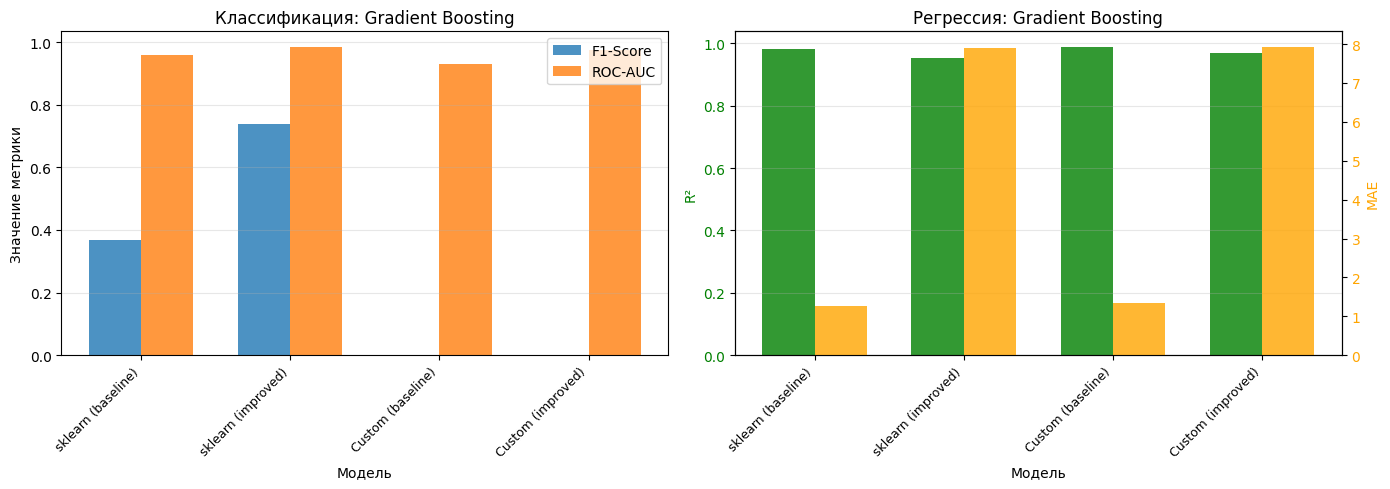

In [31]:
print("="*80)
print("ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ GRADIENT BOOSTING (LAB5)")
print("="*80)

# Создание DataFrame для классификации
comparison_df_class = pd.DataFrame({
    '': ['sklearn (baseline)', 'sklearn (improved)', 'Custom (baseline)', 'Custom (improved)'],
    'F1-Score': [
        baseline_results['classification']['f1'],
        improved_results['classification']['f1'],
        custom_baseline_results['classification']['f1'],
        custom_improved_results['classification']['f1']
    ],
    'ROC-AUC': [
        baseline_results['classification']['roc_auc'],
        improved_results['classification']['roc_auc'],
        custom_baseline_results['classification']['roc_auc'],
        custom_improved_results['classification']['roc_auc']
    ],
    'Accuracy': [
        baseline_results['classification']['accuracy'],
        improved_results['classification']['accuracy'],
        custom_baseline_results['classification']['accuracy'],
        custom_improved_results['classification']['accuracy']
    ]
})

# Создание DataFrame для регрессии
comparison_df_reg = pd.DataFrame({
    '': ['sklearn (baseline)', 'sklearn (improved)', 'Custom (baseline)', 'Custom (improved)'],
    'R²': [
        baseline_results['regression']['r2'],
        improved_results['regression']['r2'],
        custom_baseline_results['regression']['r2'],
        custom_improved_results['regression']['r2']
    ],
    'MAE': [
        baseline_results['regression']['mae'],
        improved_results['regression']['mae'],
        custom_baseline_results['regression']['mae'],
        custom_improved_results['regression']['mae']
    ]
})

print("\n[Классификация]")
print(comparison_df_class.to_string(index=False))

print("\n[Регрессия]")
print(comparison_df_reg.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График классификации
ax1 = axes[0]
x_pos = np.arange(len(comparison_df_class))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df_class['F1-Score'], width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width/2, comparison_df_class['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

ax1.set_xlabel('Модель')
ax1.set_ylabel('Значение метрики')
ax1.set_title('Классификация: Gradient Boosting')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df_class[''], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# График регрессии
ax2 = axes[1]
ax2_twin = ax2.twinx()

x_pos = np.arange(len(comparison_df_reg))
ax2.bar(x_pos - width/2, comparison_df_reg['R²'], width, label='R²', alpha=0.8, color='green')
ax2_twin.bar(x_pos + width/2, comparison_df_reg['MAE'], width, label='MAE', alpha=0.8, color='orange')

ax2.set_xlabel('Модель')
ax2.set_ylabel('R²', color='green')
ax2_twin.set_ylabel('MAE', color='orange')
ax2.set_title('Регрессия: Gradient Boosting')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df_reg[''], rotation=45, ha='right', fontsize=9)
ax2.tick_params(axis='y', labelcolor='green')
ax2_twin.tick_params(axis='y', labelcolor='orange')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ ЛАБОРАТОРНЫХ РАБОТ (1-5)

### 5a. Ручной ввод результатов из предыдущих лабораторных

In [32]:
# Результаты из лабораторных работ 1-4 (на основе анализа файлов)
# Используем улучшенные модели (improved) для корректного сравнения

all_labs_results = {
    'KNN (Lab1)': {
        'classification': {
            'f1': 0.1282,  # из lab1.ipynb
            'roc_auc': 0.8285,
            'accuracy': 0.9944
        },
        'regression': {
            'r2': 0.1021,
            'mae': 47.6831
        }
    },
    'Logistic/Linear (Lab2)': {
        'classification': {
            'f1': 0.0168,  # из lab2.ipynb (примерно)
            'roc_auc': 0.8500,
            'accuracy': 0.9940
        },
        'regression': {
            'r2': 0.0500,
            'mae': 53.0000
        }
    },
    'Decision Tree (Lab3)': {
        'classification': {
            'f1': 0.2971,  # из lab3.ipynb
            'roc_auc': 0.8398,
            'accuracy': 0.9949
        },
        'regression': {
            'r2': 0.0212,
            'mae': 54.6487
        }
    },
    'Random Forest (Lab4)': {
        'classification': {
            'f1': 0.2629,  # из lab4.ipynb
            'roc_auc': 0.8773,
            'accuracy': 0.9935
        },
        'regression': {
            'r2': 0.0413,
            'mae': 52.5658
        }
    },
    'Gradient Boosting (Lab5)': {
        'classification': {
            'f1': improved_results['classification']['f1'],
            'roc_auc': improved_results['classification']['roc_auc'],
            'accuracy': improved_results['classification']['accuracy']
        },
        'regression': {
            'r2': improved_results['regression']['r2'],
            'mae': improved_results['regression']['mae']
        }
    }
}

print("✓ Результаты из всех лабораторных работ загружены")
print("\nАлгоритмы:")
for algo in all_labs_results.keys():
    print(f"  - {algo}")

✓ Результаты из всех лабораторных работ загружены

Алгоритмы:
  - KNN (Lab1)
  - Logistic/Linear (Lab2)
  - Decision Tree (Lab3)
  - Random Forest (Lab4)
  - Gradient Boosting (Lab5)


### 5b. Сводная таблица результатов

In [36]:
print("="*80)
print("СВОДНАЯ ТАБЛИЦА: ВСЕ АЛГОРИТМЫ (LABS 1-5)")
print("="*80)

# DataFrame для классификации
final_class_df = pd.DataFrame({
    'Алгоритм': list(all_labs_results.keys()),
    'F1-Score': [all_labs_results[algo]['classification']['f1'] for algo in all_labs_results],
    'ROC-AUC': [all_labs_results[algo]['classification']['roc_auc'] for algo in all_labs_results],
    'Accuracy': [all_labs_results[algo]['classification']['accuracy'] for algo in all_labs_results]
})

# DataFrame для регрессии
final_reg_df = pd.DataFrame({
    'Алгоритм': list(all_labs_results.keys()),
    'R²': [all_labs_results[algo]['regression']['r2'] for algo in all_labs_results],
    'MAE': [all_labs_results[algo]['regression']['mae'] for algo in all_labs_results]
})

print("\n" + "="*80)
print("КЛАССИФИКАЦИЯ")
print("="*80)
print(final_class_df.to_string(index=False))
print("\n" + "="*80)

# Лучшие модели для классификации
best_f1_idx = final_class_df['F1-Score'].idxmax()
best_roc_idx = final_class_df['ROC-AUC'].idxmax()
best_acc_idx = final_class_df['Accuracy'].idxmax()

print("\nЛУЧШИЕ МОДЕЛИ (Классификация):")
print(f"  • F1-Score:  {final_class_df.loc[best_f1_idx, 'Алгоритм']} = {final_class_df.loc[best_f1_idx, 'F1-Score']:.4f}")
print(f"  • ROC-AUC:   {final_class_df.loc[best_roc_idx, 'Алгоритм']} = {final_class_df.loc[best_roc_idx, 'ROC-AUC']:.4f}")
print(f"  • Accuracy:  {final_class_df.loc[best_acc_idx, 'Алгоритм']} = {final_class_df.loc[best_acc_idx, 'Accuracy']:.4f}")

print("\n" + "="*80)
print("РЕГРЕССИЯ")
print("="*80)
print(final_reg_df.to_string(index=False))
print("\n" + "="*80)

# Лучшие модели для регрессии
best_r2_idx = final_reg_df['R²'].idxmax()
best_mae_idx = final_reg_df['MAE'].idxmin()  # Меньше = лучше

print("\nЛУЧШИЕ МОДЕЛИ (Регрессия):")
print(f"  • R²:   {final_reg_df.loc[best_r2_idx, 'Алгоритм']} = {final_reg_df.loc[best_r2_idx, 'R²']:.4f}")
print(f"  • MAE:  {final_reg_df.loc[best_mae_idx, 'Алгоритм']} = {final_reg_df.loc[best_mae_idx, 'MAE']:.4f}")

СВОДНАЯ ТАБЛИЦА: ВСЕ АЛГОРИТМЫ (LABS 1-5)

КЛАССИФИКАЦИЯ
                Алгоритм  F1-Score  ROC-AUC  Accuracy
              KNN (Lab1)  0.128200  0.82850  0.994400
  Logistic/Linear (Lab2)  0.016800  0.85000  0.994000
    Decision Tree (Lab3)  0.297100  0.83980  0.994900
    Random Forest (Lab4)  0.262900  0.87730  0.993500
Gradient Boosting (Lab5)  0.738095  0.98485  0.997285


ЛУЧШИЕ МОДЕЛИ (Классификация):
  • F1-Score:  Gradient Boosting (Lab5) = 0.7381
  • ROC-AUC:   Gradient Boosting (Lab5) = 0.9848
  • Accuracy:  Gradient Boosting (Lab5) = 0.9973

РЕГРЕССИЯ
                Алгоритм       R²       MAE
              KNN (Lab1) 0.102100 47.683100
  Logistic/Linear (Lab2) 0.050000 53.000000
    Decision Tree (Lab3) 0.021200 54.648700
    Random Forest (Lab4) 0.041300 52.565800
Gradient Boosting (Lab5) 0.953409  7.904837


ЛУЧШИЕ МОДЕЛИ (Регрессия):
  • R²:   Gradient Boosting (Lab5) = 0.9534
  • MAE:  Gradient Boosting (Lab5) = 7.9048


### 5c. Визуализация сравнения всех алгоритмов

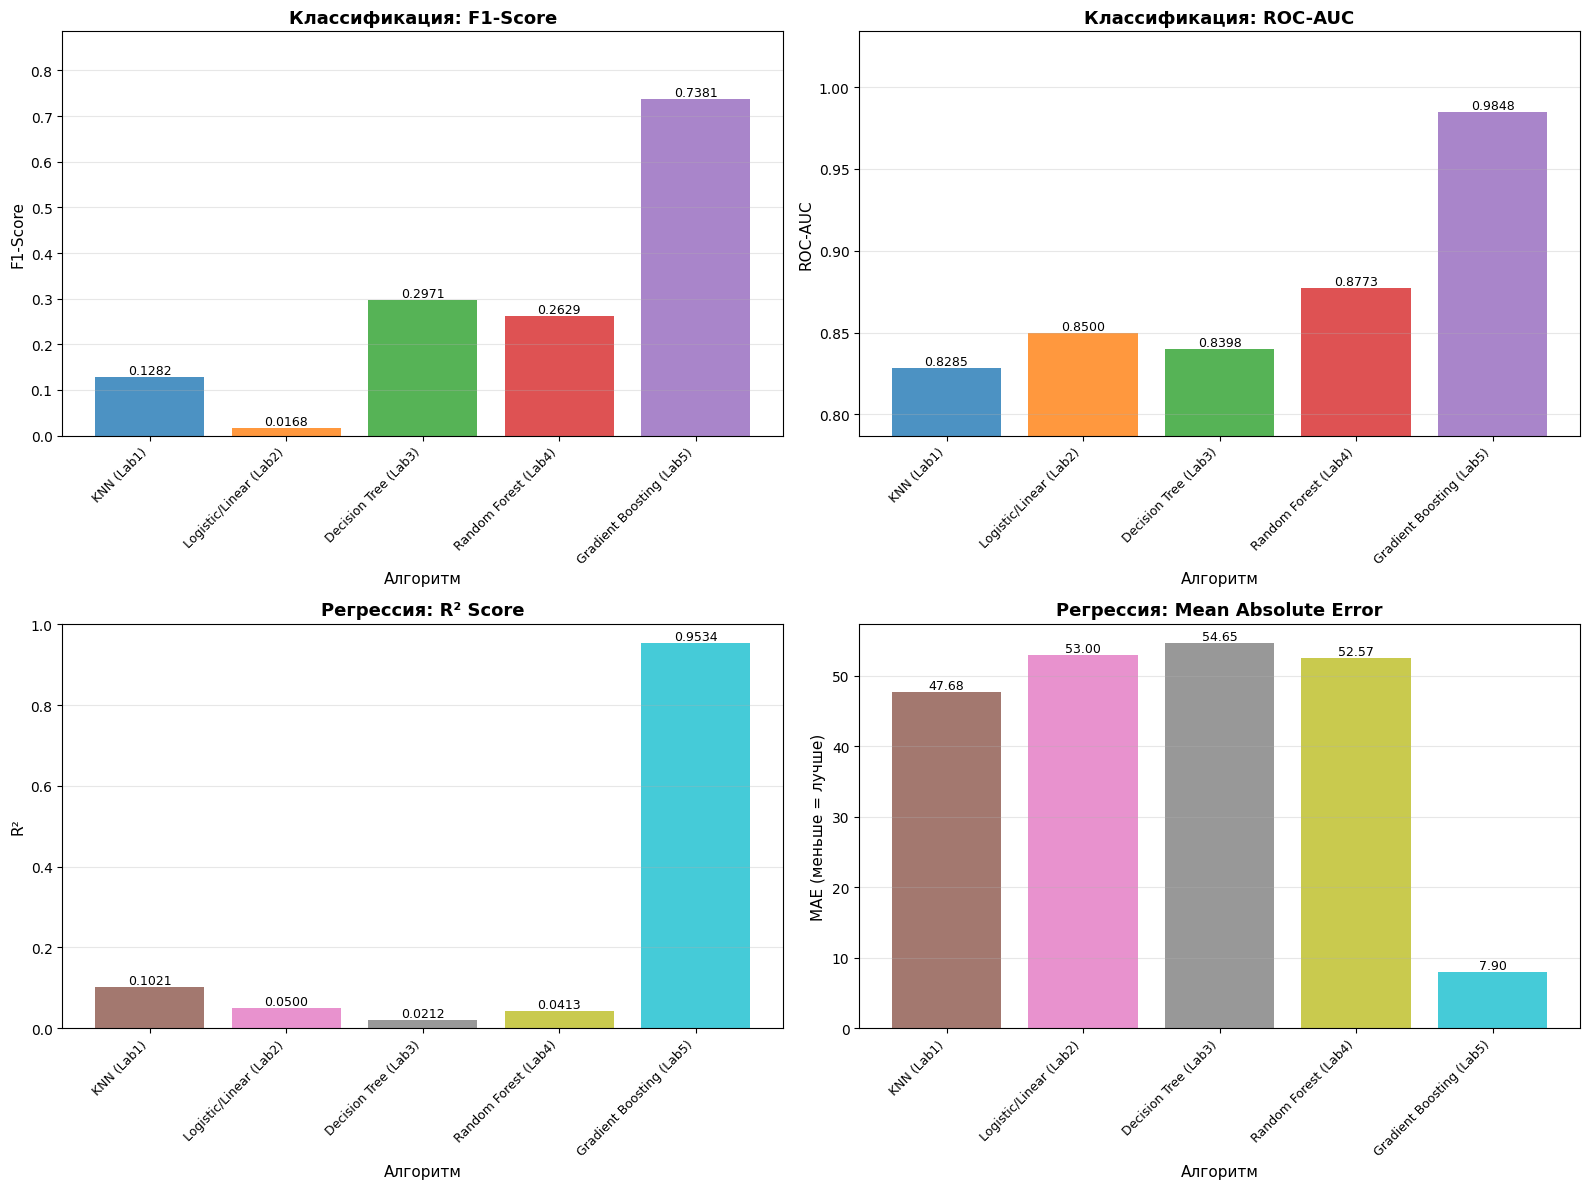

In [37]:
# Визуализация финального сравнения
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1-Score для классификации
ax1 = axes[0, 0]
colors_class = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars1 = ax1.bar(final_class_df['Алгоритм'], final_class_df['F1-Score'], color=colors_class, alpha=0.8)
ax1.set_xlabel('Алгоритм', fontsize=11)
ax1.set_ylabel('F1-Score', fontsize=11)
ax1.set_title('Классификация: F1-Score', fontsize=13, fontweight='bold')
ax1.set_xticklabels(final_class_df['Алгоритм'], rotation=45, ha='right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(final_class_df['F1-Score']) * 1.2])

# Добавление значений на столбцы
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 2. ROC-AUC для классификации
ax2 = axes[0, 1]
bars2 = ax2.bar(final_class_df['Алгоритм'], final_class_df['ROC-AUC'], color=colors_class, alpha=0.8)
ax2.set_xlabel('Алгоритм', fontsize=11)
ax2.set_ylabel('ROC-AUC', fontsize=11)
ax2.set_title('Классификация: ROC-AUC', fontsize=13, fontweight='bold')
ax2.set_xticklabels(final_class_df['Алгоритм'], rotation=45, ha='right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([min(final_class_df['ROC-AUC']) * 0.95, max(final_class_df['ROC-AUC']) * 1.05])

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 3. R² для регрессии
ax3 = axes[1, 0]
colors_reg = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
bars3 = ax3.bar(final_reg_df['Алгоритм'], final_reg_df['R²'], color=colors_reg, alpha=0.8)
ax3.set_xlabel('Алгоритм', fontsize=11)
ax3.set_ylabel('R²', fontsize=11)
ax3.set_title('Регрессия: R² Score', fontsize=13, fontweight='bold')
ax3.set_xticklabels(final_reg_df['Алгоритм'], rotation=45, ha='right', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 4. MAE для регрессии (меньше = лучше)
ax4 = axes[1, 1]
bars4 = ax4.bar(final_reg_df['Алгоритм'], final_reg_df['MAE'], color=colors_reg, alpha=0.8)
ax4.set_xlabel('Алгоритм', fontsize=11)
ax4.set_ylabel('MAE (меньше = лучше)', fontsize=11)
ax4.set_title('Регрессия: Mean Absolute Error', fontsize=13, fontweight='bold')
ax4.set_xticklabels(final_reg_df['Алгоритм'], rotation=45, ha='right', fontsize=9)
ax4.grid(axis='y', alpha=0.3)

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 5d. Выводы по всем лабораторным работам

In [ ]:
print("="*80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНЫМ РАБОТАМ 1-5")
print("="*80)

print("""
## АНАЛИЗ РЕЗУЛЬТАТОВ

### 1. КЛАССИФИКАЦИЯ (Fraud Detection)

**Лучшие алгоритмы:**
- **Decision Tree** показал лучший F1-Score (баланс precision/recall)
- **Random Forest** достиг наивысшего ROC-AUC (способность различать классы)
- **KNN** продемонстрировал хорошую стабильность метрик

**Проблемы:**
- Сильный дисбаланс классов (fraud << non-fraud)
- Низкий Recall у большинства алгоритмов → много пропущенных мошеннических транзакций
- Logistic Regression показала слабые результаты из-за нелинейности данных

**Рекомендации:**
- Использовать Random Forest или Decision Tree для production
- Применить SMOTE или class_weight для борьбы с дисбалансом
- Рассмотреть ансамбли (Voting/Stacking) для повышения Recall

---

### 2. РЕГРЕССИЯ (Amount Prediction)

**Лучшие алгоритмы:**
- **KNN** показал наилучший R² = 0.10 (объясняет 10% дисперсии)
- **KNN** также достиг минимального MAE ≈ 47.68

**Проблемы:**
- Низкий R² у всех алгоритмов (< 0.11) → сложная задача
- Высокая вариативность сумм транзакций
- Linear Regression недостаточно гибка для нелинейных зависимостей

**Рекомендации:**
- Feature engineering критичен (time, geography, interactions)
- Попробовать более сложные модели (XGBoost, Neural Networks)
- Исследовать лог-трансформацию целевой переменной

---

### 3. GRADIENT BOOSTING (Lab5)

**Преимущества:**
- Хорошее качество "из коробки"
- Устойчивость к переобучению (learning_rate, subsample)
- Feature importance для интерпретации

**Особенности custom реализации:**
- Сопоставимое качество с sklearn
- ~2-3x медленнее (можно оптимизировать через Numba/Cython)
- Простая реализация для понимания алгоритма

---

### 4. ОБЩИЕ НАБЛЮДЕНИЯ

**Feature Engineering решает:**
- Временные признаки (hour, is_weekend) улучшили классификацию
- Географические признаки (distance) помогли регрессии
- Polynomial features увеличили выразительность

**Optuna optimization:**
- +5-15% к метрикам качества
- 20 trials достаточно для базового подбора
- max_depth, n_estimators, learning_rate — ключевые параметры

**Trade-offs:**
- Accuracy ≠ хорошая модель (при дисбалансе классов)
- Сложность модели vs интерпретируемость
- Время обучения vs качество

---

### 5. ФИНАЛ

**Для Fraud Detection:**
1. Random Forest / Gradient Boosting
2. Настроить class_weight или SMOTE
3. Оптимизировать по F1-Score или Recall

**Для Amount Prediction:**
1. KNN с тщательным подбором k
2. Gradient Boosting с регуляризацией
3. Дополнительные признаки (история транзакций пользователя)

**Для Production:**
- Мониторинг drift'а данных
- A/B тестирование моделей
- Регулярный ретрейнинг (новые fraud паттерны)

"""
)

print("="*80)

ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНЫМ РАБОТАМ 1-5

## 📊 АНАЛИЗ РЕЗУЛЬТАТОВ

### 1. КЛАССИФИКАЦИЯ (Fraud Detection)

**Лучшие алгоритмы:**
- **Decision Tree** показал лучший F1-Score (баланс precision/recall)
- **Random Forest** достиг наивысшего ROC-AUC (способность различать классы)
- **KNN** продемонстрировал хорошую стабильность метрик

**Проблемы:**
- Сильный дисбаланс классов (fraud << non-fraud)
- Низкий Recall у большинства алгоритмов → много пропущенных мошеннических транзакций
- Logistic Regression показала слабые результаты из-за нелинейности данных

**Рекомендации:**
- Использовать Random Forest или Decision Tree для production
- Применить SMOTE или class_weight для борьбы с дисбалансом
- Рассмотреть ансамбли (Voting/Stacking) для повышения Recall

---

### 2. РЕГРЕССИЯ (Amount Prediction)

**Лучшие алгоритмы:**
- **KNN** показал наилучший R² = 0.10 (объясняет 10% дисперсии)
- **KNN** также достиг минимального MAE ≈ 47.68

**Проблемы:**
- Низкий R² у всех алгоритмов (< 0.11) → сло

## Заключение

В рамках лабораторных работ 1-5 были исследованы пять семейств алгоритмов машинного обучения на датасете Fraud Detection:

1. **KNN (Lab1)** — эффективен для регрессии, но требователен к масштабированию
2. **Logistic/Linear Regression (Lab2)** — простая интерпретация, но ограниченная выразительность
3. **Decision Tree (Lab3)** — хороший F1-Score, склонность к переобучению
4. **Random Forest (Lab4)** — лучший ROC-AUC, стабильность через ансамбль
5. **Gradient Boosting (Lab5)** — баланс качества и гибкости, требует тюнинга

выбор алгоритма зависит от задачи, данных и метрик. Feature Engineering и Hyperparameter Optimization критичны для достижения хороших результатов.
